# Spectra2Prop Showcase

## Direct Prediction of Chemical Class from MS/MS Spectra

This notebook demonstrates the "structure-less" paradigm: predicting chemical properties (Superclass) directly from raw spectral data using a Deep Learning model (1D-CNN).

In [76]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import importlib

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from torch.utils.data import DataLoader

import spectra2prop.data.dataset

from spectra2prop.data.dataset import SpectrumDataset
from spectra2prop.data.loader import download_data
from spectra2prop.models.cnn1d import SpectralCNN
from spectra2prop.utils.visualization import visualize_embeddings

%matplotlib inline

## 1. Load Data
We download and load the dataset.

In [ ]:
DATA_URL = "https://raw.githubusercontent.com/matchms/matchms/master/tests/testdata/pesticides.mgf"
LOCAL_FILE = "../data/pesticides.mgf"

if not os.path.exists(LOCAL_FILE):
    print(f"Downloading dataset to {LOCAL_FILE}...")
    os.makedirs(os.path.dirname(LOCAL_FILE), exist_ok=True)
    download_data(DATA_URL, LOCAL_FILE)
else:
    print(f"Dataset found at {LOCAL_FILE}")

dataset = SpectrumDataset(LOCAL_FILE, mode='train')
print(f"Classes: {dataset.idx_to_class}")

num_classes = len(dataset.class_to_idx)

Dataset found at ../data/pesticides.mgf
Loading spectra...
Loaded 76 spectra. Applying filters...


100%|██████████| 76/76 [00:00<00:00, 1080.97it/s]

Retained 76 spectra after filtering.
Extracting labels...
Found 45 unique classes: ['Pesticide2_Thidiazuron_C9H8N4OS_1-Phenyl-3-(1,2,3-thiadiazol-5-yl)urea', 'Pesticide6_Diniconazole_C15H17Cl2N3O_(1E)-1-(2,4-Dichlorphenyl)-4,4-dimethyl-2-(1H-1,2,4-triazol-1-yl)pent-1-en-3-ol', 'Pesticide3_Hexaflumuron_C16H8Cl2F6N2O3_', 'Pesticide3_Chlorfluazuron_C20H9Cl3F5N3O3_Benzamide, N-[[[3,5-dichloro-4-[[3-chloro-5-(trifluoromethyl)-2-pyridinyl]oxy]phenyl]amino]carbonyl]-2,6-difluoro-', "Pesticide3_Fluometuron_C10H11F3N2O_Urea, N,N-dimethyl-N'-[3-(trifluoromethyl)phenyl]-"]...
Dataset (train): 60 samples.
Classes: {0: 'Pesticide1_Acephate_C4H10NO3PS_O,S-Dimethyl acetylphosphoramidothioate', 1: 'Pesticide2_Thidiazuron_C9H8N4OS_1-Phenyl-3-(1,2,3-thiadiazol-5-yl)urea', 2: 'Pesticide2_Thiophanate-methyl_C12H14N4O4S2_', 3: 'Pesticide3_Chlorfluazuron_C20H9Cl3F5N3O3_Benzamide, N-[[[3,5-dichloro-4-[[3-chloro-5-(trifluoromethyl)-2-pyridinyl]oxy]phenyl]amino]carbonyl]-2,6-difluoro-', 4: "Pesticide3_Chloroto

## 2. Visualize Input Spectra
Let's look at what the model sees: distinct spectral patterns for different classes.

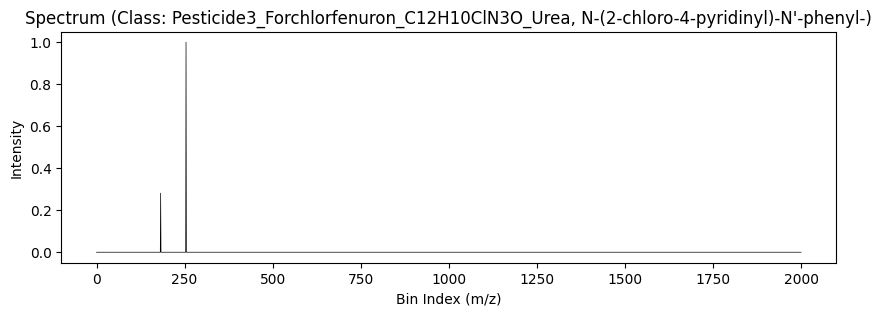

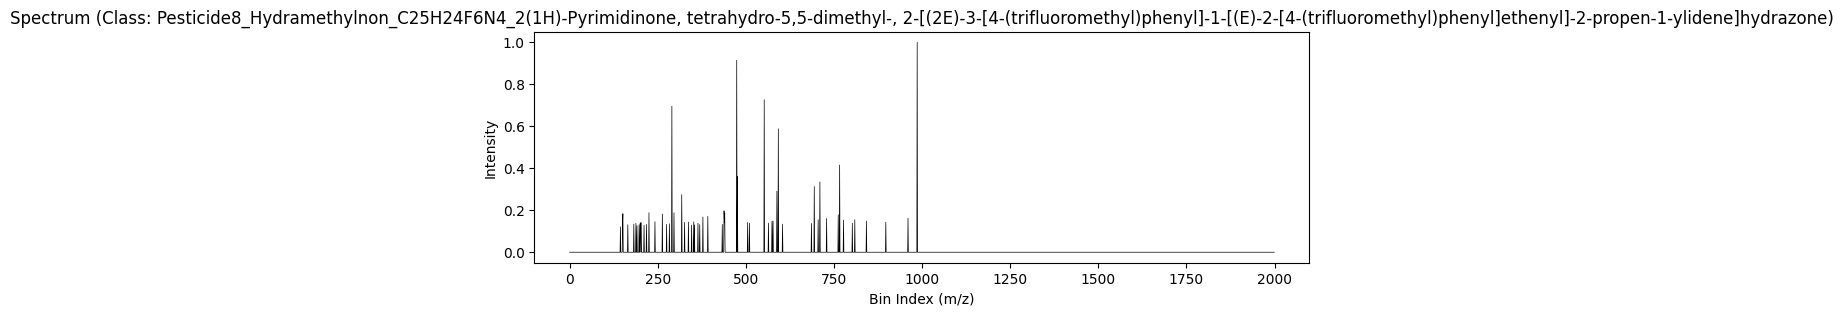

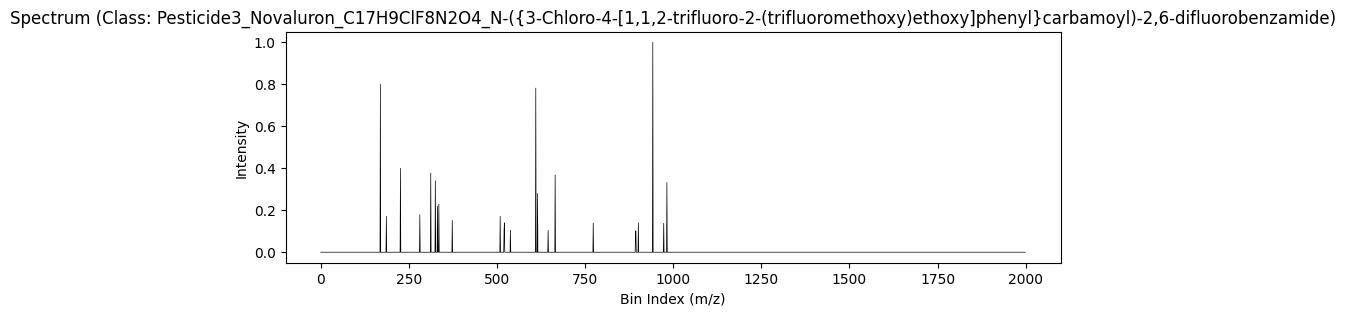

In [ ]:
def plot_spectrum(idx):
    vec, label = dataset[idx]
    lbl_name = dataset.idx_to_class[label.item()]
    
    plt.figure(figsize=(10, 3))
    plt.plot(vec.squeeze().numpy(), color='black', linewidth=0.5)
    plt.title(f"Spectrum (Class: {lbl_name})")
    plt.xlabel("Bin Index (m/z)")
    plt.ylabel("Intensity")
    plt.show()

plot_spectrum(0)
if len(dataset) > 10:
    plot_spectrum(10)
if len(dataset) > 50:
    plot_spectrum(50)

## 3. Train Model
We train the 1D-CNN model on the spectral data.

In [ ]:
from torch.utils.data import random_split
import torch.nn as nn
import torch.optim as optim

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = SpectralCNN(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
print(f"Training for {num_epochs} epochs...")
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

model.eval()
print("Training Complete!")

Training for 20 epochs...
Epoch 1, Loss: 4.1916
Epoch 2, Loss: 3.6380
Epoch 3, Loss: 3.0808
Epoch 4, Loss: 2.8277
Epoch 5, Loss: 2.6517
Epoch 6, Loss: 2.4874
Epoch 7, Loss: 2.2306
Epoch 8, Loss: 2.0409
Epoch 9, Loss: 1.7864
Epoch 10, Loss: 1.5556
Epoch 11, Loss: 1.4197
Epoch 12, Loss: 1.1923
Epoch 13, Loss: 1.0810
Epoch 14, Loss: 0.9021
Epoch 15, Loss: 0.7909
Epoch 16, Loss: 0.6735
Epoch 17, Loss: 0.5615
Epoch 18, Loss: 0.4843
Epoch 19, Loss: 0.4253
Epoch 20, Loss: 0.3696
Training Complete!


## 4. Model Evaluation
We calculate accuracy on the test set and visualize specific predictions.

Test Set Accuracy: 66.67%

Visualizing Model Predictions on Test Set...

--- Sample 11 ---
True Class: Pesticide3_Forchlorfenuron_C12H10ClN3O_Urea, N-(2-chloro-4-pyridinyl)-N'-phenyl-
Predictions:
  1. Pesticide3_Forchlorfenuron_C12H10ClN3O_Urea, N-(2-chloro-4-pyridinyl)-N'-phenyl- (4.73%)
  2. Pesticide5_Fipronil_C12H4Cl2F6N4OS_5-Amino-1-[2,6-dichloro-4-(trifluoromethyl)phenyl]-4-[(trifluoromethyl)sulfinyl]-1H-pyrazole-3-carbonitrile (3.81%)
  3. Pesticide5_Prothioconazole_C14H15Cl2N3OS_Redigo (3.38%)


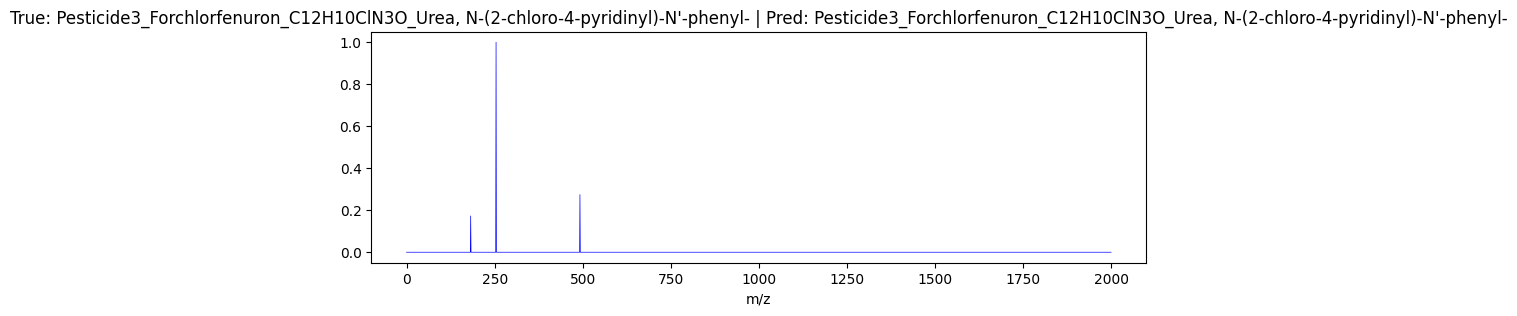


--- Sample 7 ---
True Class: Pesticide4_Tebufenozide_C22H28N2O2_Benzoic acid, 3,5-dimethyl-, 1-(1,1-dimethylethyl)-2-(4-ethylbenzoyl)hydrazide
Predictions:
  1. Pesticide4_Tebufenozide_C22H28N2O2_Benzoic acid, 3,5-dimethyl-, 1-(1,1-dimethylethyl)-2-(4-ethylbenzoyl)hydrazide (4.18%)
  2. Pesticide4_Doramectin_C50H74O14_Dectomax (3.65%)
  3. Pesticide4_Boscalid_C18H12Cl2N2O_3-Pyridinecarboxamide, 2-chloro-N-(4'-chloro[1,1'-biphenyl]-2-yl)- (3.60%)


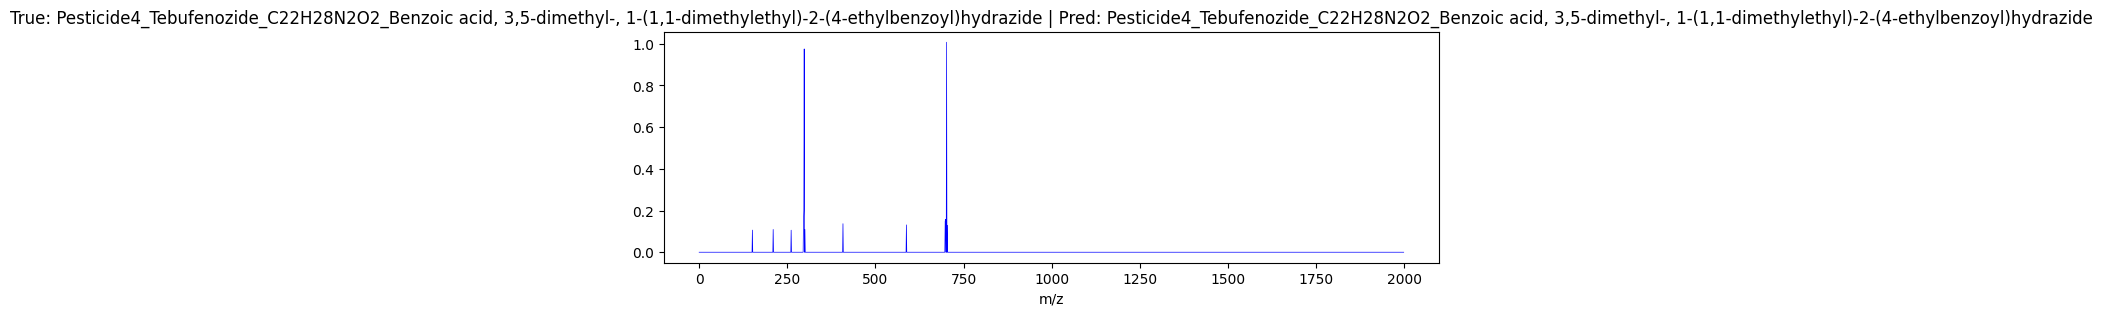


--- Sample 0 ---
True Class: Pesticide4_Ivermectin_C48H74O14_22,23-dihydroavermectin B1
Predictions:
  1. Pesticide4_Tebufenozide_C22H28N2O2_Benzoic acid, 3,5-dimethyl-, 1-(1,1-dimethylethyl)-2-(4-ethylbenzoyl)hydrazide (4.12%)
  2. Pesticide4_Doramectin_C50H74O14_Dectomax (4.00%)
  3. Pesticide5_Clothianidin_C6H8ClN5O2S_[C(E)]-N-[(2-Chloro-5-thiazolyl)methyl]-N?-methyl-N?-nitroguanidine (3.80%)


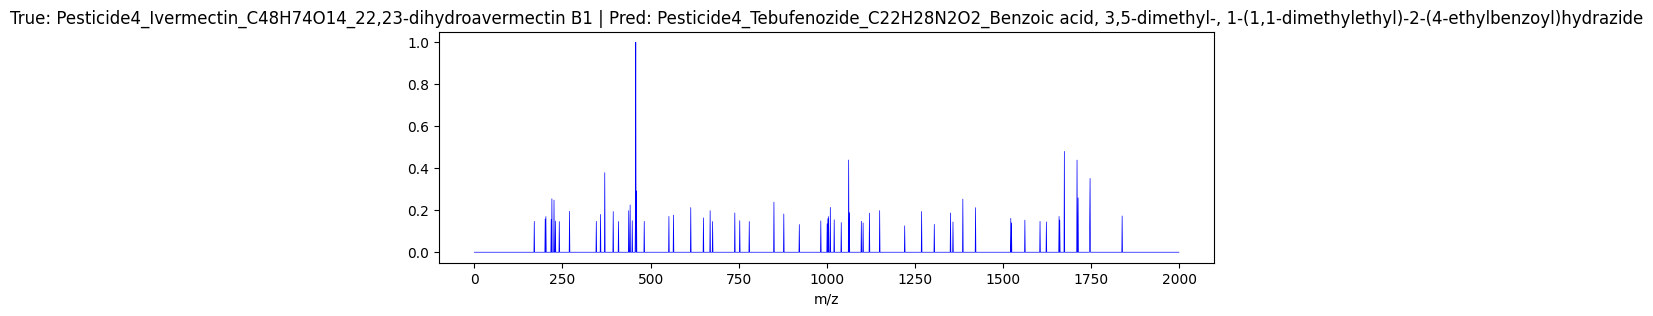

In [79]:
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs, _ = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

import random

def predict_and_plot(idx):
    vec, label = test_dataset[idx]
    true_name = dataset.idx_to_class[label.item()]
    
    with torch.no_grad():
        input_vec = vec.unsqueeze(0)
        logits, _ = model(input_vec)
        probs = torch.softmax(logits, dim=1)
        
        top_probs, top_idxs = torch.topk(probs, 3)
        
    print(f"\n--- Sample {idx} ---")
    print(f"True Class: {true_name}")
    print("Predictions:")
    for i in range(3):
        p_prob = top_probs[0][i].item()
        p_idx = top_idxs[0][i].item()
        p_name = dataset.idx_to_class[p_idx]
        print(f"  {i+1}. {p_name} ({p_prob*100:.2f}%)")

    plt.figure(figsize=(10, 3))
    plt.plot(vec.squeeze().numpy(), color='blue', linewidth=0.5)
    pred_name = dataset.idx_to_class[top_idxs[0][0].item()]
    plt.title(f"True: {true_name} | Pred: {pred_name}")
    plt.xlabel("m/z")
    plt.show()

print("\nVisualizing Model Predictions on Test Set...")
if len(test_dataset) > 0:
    test_indices = list(range(len(test_dataset)))
    k = min(3, len(test_indices))
    random_samples = random.sample(test_indices, k)

    for idx in random_samples:
        predict_and_plot(idx)
else:
    print("Test dataset is empty.")

Extracting embeddings for visualization...
Running UMAP...


/opt/miniconda3/envs/tahoe/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/miniconda3/envs/tahoe/lib/python3.13/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/Users/rayk/GitHub Repos/Spectra2Prop/spectra2prop/utils/visualization.py:50: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  os.makedirs(output_dir, exist_ok=True)


Saved UMAP plot to images/umap_projection.png


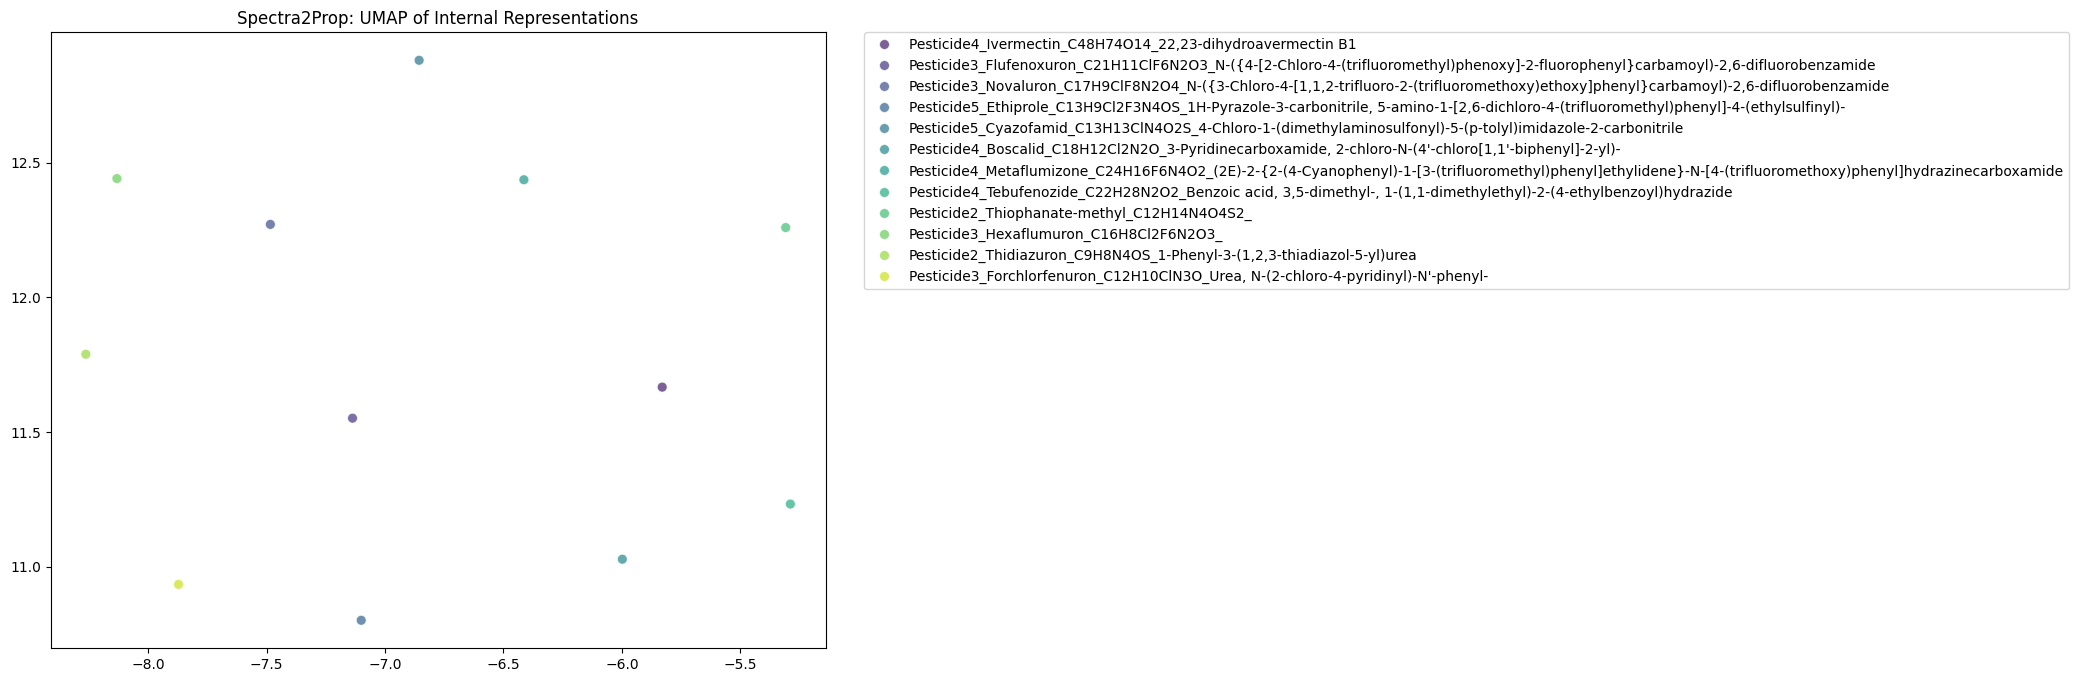

In [82]:
device = "cpu"
output_dir = "images"

from spectra2prop.utils.visualization import visualize_embeddings

if 'test_dataset' in locals() and hasattr(test_dataset, 'dataset') and not hasattr(test_dataset, 'idx_to_class'):
    test_dataset.idx_to_class = test_dataset.dataset.idx_to_class
if 'test_dataset' in locals() or 'test_dataset' in globals():
    visualize_embeddings(dataset=test_dataset, model=model, device=device, output_dir=output_dir)
elif 'dataset' in locals() or 'dataset' in globals():
    visualize_embeddings(dataset=dataset, model=model, device=device, output_dir=output_dir)
else:
    print("Error: Neither 'test_dataset' nor 'dataset' found.")
        
